In [14]:
import nltk, re, pprint,random
from nltk import pos_tag, word_tokenize, NaiveBayesClassifier, classify, bigrams
import pandas as pd
from operator import itemgetter
from collections import Counter
from __future__ import division  # Python 2 users only

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.probability import FreqDist
from nltk.classify import SklearnClassifier
from nltk.tokenize import TreebankWordTokenizer

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

%config InlineBackend.figure_format = 'retina'
%pylab inline
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

**Deliverables
The deliverable for this assignment is a file with the python scripts, outputs (including plots & tables where applicable) and your answers to the various questions. Do not forget to write the names of all group members. **

In [15]:
# df_data = pd.read_csv('/Users/brettscroggins/Downloads/Train_rev1.csv')
df_data = pd.read_csv('Train_rev1.csv')

#df_data = pd.read_csv('/Users/daniellediehl/Documents/MSBA/Fall_Classes/Text_Analysis/Assignment_1/Train_rev1.csv')

In [16]:
df_data[:3]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk


In [17]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

In [18]:
top_percentile = df_data.SalaryNormalized>df_data.SalaryNormalized.quantile(.75)
df_data['BinarySalary'] = np.where(top_percentile, 1, 0)
b_salary = df_data['BinarySalary']
df_data['BinarySalary'].value_counts()

0    187167
1     57601
Name: BinarySalary, dtype: int64

In [19]:
####RCD -we probably need to take a random sample of the DF, so we can get the right salaries to match up for Part B 

smaller_df = df_data.sample(1000, random_state=100)
#smaller_df.sort_values(['SalaryNormalized'],ascending = False).iloc[1].FullDescription

In [20]:
job_desc_list=smaller_df.FullDescription.values.tolist()
job_desc_list[0] #the first job description (complete)
words=[]
for i in range(0,len(job_desc_list)):
    words1=word_tokenize(job_desc_list[i])
    words.append(words1)

In [21]:
job_words = [item for sublist in words for item in sublist]

In [22]:
len(job_words)

271497

# Part A

**A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?**

Hint: nltk.org is a great resource for exploring text mining with Python. There are many examples that are similar to the questions in this assignment.  

In [27]:
tagged = nltk.pos_tag(job_words)
counts = Counter(tag for word,tag in tagged)
most_com_words = counts.most_common()[:5]
print 'the most common parts of speech are '
most_com_words
#NN: noun, common/singular/mass

[('NN', 46509), ('NNP', 34237), ('IN', 26422), ('JJ', 22262), ('DT', 20495)]

**A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.**

Hint: Check http://www.garysieling.com/blog/exploring-zipfs-law-with-python-nltk-scipy-and-matplotlib 

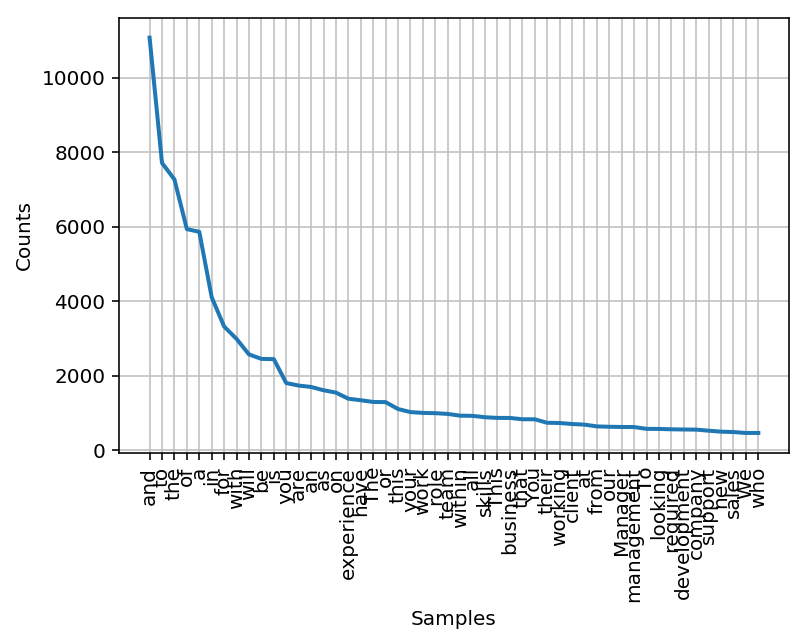

[('and', 11076), ('to', 7712), ('the', 7269), ('of', 5936), ('a', 5863)]

In [22]:
job_words_no_punc = [w for w in job_words if w.isalpha()]
freqdist = FreqDist(job_words_no_punc)
top_100=freqdist.most_common(100)

freqdist.plot(50, cumulative=False) #change this to 100 and make it look pretty


print 'A few words occur very frequently, a medium number of word have, well, medium frequency!, and any words occur very infrequently.' 
print 'The top words and their frequecies are: ',top_100 [:5]

#### Our graph supports Zipf's law because we have only a few words that have very high frequencies, a medium number of words with medium frequencies, and many words with low frequencies.

**A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What are their frequencies?**


In [25]:
filtered_words = [word for word in job_words if word not in stopwords.words('english')]  ##I think filtered words wasn't working before because we hadn't tokenized
filtered_words = [w.lower() for w in filtered_words if w.isalpha()]
#filtered_words
porter=nltk.PorterStemmer()
filtered_words= [porter.stem(t) for t in filtered_words] #tokens=word tokenization
filtered_freq = FreqDist(filtered_words)
filtered_freq.most_common(10)
##'The' will be removed once we get our 'words' list into lowercase

[(u'manag', 2209),
 (u'work', 2100),
 (u'experi', 1829),
 (u'develop', 1412),
 ('the', 1355),
 (u'busi', 1256),
 ('team', 1255),
 ('role', 1237),
 ('client', 1149),
 (u'skill', 1083)]

# Part B (predict salary from job description)

In this section, you will create classification models to predict high (75th percentile and above) or low (below 75th percentile) salary from the text contained in the job descriptions. Ignore all other data provided on kaggle.com that is not text (except the actual salary data, which you need to create the binary output of high/low salary).    
Get the training data on kaggle.com (train_rev1) (do not use the validation data provided on kaggle.com). Use the Naïve Bayes classifier to classify job descriptions into high and low salary categories (we will discuss the theory of Naïve Bayes later in this course). There are two versions of Naïve Bayes – binomial and multinomial; for the moment, let’s not bother about the theoretical underpinnings! You can use either one for this assignment. For all models below, show the confusion matrix.
Hint: For part B, check out   http://www.nltk.org/book/ch06.html (esp 1.3) for illustrations.

Also look at http://nbviewer.ipython.org/gist/rjweiss/7158866 (you may have to download additional Python libraries than the ones I have mentioned before) 

**B1. Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? **

In [28]:
trainset_size = int(round(len(job_desc_list)*0.75))
X_train = np.array([''.join(el) for el in job_desc_list[:trainset_size]])
y_train = np.array([el for el in smaller_df.BinarySalary[:trainset_size]])

X_test = np.array([''.join(el) for el in job_desc_list[trainset_size:]])
y_test = np.array([el for el in smaller_df.BinarySalary[trainset_size:]])


In [29]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 

In [30]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

nb_classifier = MultinomialNB().fit(X_train_vec, y_train)
y_nb_predicted = nb_classifier.predict(X_test_vec)


In [31]:
str(metrics.accuracy_score(y_test, y_nb_predicted))

'0.816'

In [32]:
metrics.confusion_matrix(y_test, y_nb_predicted)

array([[168,  27],
       [ 19,  36]])

**B2. Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained.**


Reed: 
    We believe that lemmatization will help improve accuracy of the classification, but since the accuracy is already at 81.6%, not all that much. 
    Lemmatization decreases the number of words in the corpus. 
    Combining certain words increases the numerator and decreases the denomerator for the likelihood score. 
    Lemmatization has the greatest impact on conjugated verbs (rowing, rowed, rows) and possessive nouns (salary, salaries). 
    

In [34]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = TreebankWordTokenizer().tokenize, preprocessor = None, stop_words = None, max_features = 5000) 

In [36]:
X_train_vec_tok = vectorizer.fit_transform(X_train)
X_test_vec_tok = vectorizer.transform(X_test)

nb_classifier_tok = MultinomialNB().fit(X_train_vec_tok, y_train)
y_nb_predicted_tok = nb_classifier_tok.predict(X_test_vec_tok)

str(metrics.accuracy_score(y_test, y_nb_predicted_tok))

'0.828'

In [37]:
metrics.confusion_matrix(y_test, y_nb_predicted_tok)

array([[169,  26],
       [ 17,  38]])

**B3. Now speculate whether stopwords removal from the original data would help increase the accuracy of the model. Take out the stopwords (but do not lemmatize), build a classification model and check the accuracy, and compare with that in B1 & B2.   
Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.** 

In [38]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer=None, preprocessor = None, stop_words = 'english', max_features = 5000)

In [39]:
X_train_vec_stop = vectorizer.fit_transform(X_train)
X_test_vec_stop = vectorizer.transform(X_test)

nb_classifier_stop = MultinomialNB().fit(X_train_vec_stop, y_train)
y_nb_predicted_stop = nb_classifier_stop.predict(X_test_vec_stop)
str(metrics.accuracy_score(y_test, y_nb_predicted_stop))

'0.816'

In [40]:
metrics.confusion_matrix(y_test, y_nb_predicted_stop)

array([[168,  27],
       [ 19,  36]])

In [41]:
N = 10
vocabulary = np.array([t for t, i in sorted(vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
topN = np.argsort(nb_classifier_stop.coef_[0])[-N:]
vocabulary[topN]

array([u'working', u'client', u'development', u'work', u'skills', u'team',
       u'role', u'management', u'business', u'experience'],
      dtype='<U28')

In [45]:
# store the vocabulary of X_train
X_train_tokens = vectorizer.get_feature_names()

# number of times each token appears across all zero (low salary) class
zero_token_count = nb_classifier_stop.feature_count_[0, :]

# number of times each token appears across all one (high salary) class
one_token_count = nb_classifier_stop.feature_count_[1, :]

# # create a DataFrame of tokens with their separate high salary and low salary counts
tokens = pd.DataFrame({'token':X_train_tokens, 'Low_Salary':zero_token_count, 'High_Salary':one_token_count}).set_index('token')

# add 1 to the high salary and low salary counts to avoid dividing by 0
tokens['Low_Salary'] = tokens.Low_Salary + 1
tokens['High_Salary'] = tokens.High_Salary + 1

# convert the zero and one counts into frequencies
tokens['Low_Salary'] = tokens.Low_Salary / nb_classifier_stop.class_count_[0]
tokens['High_Salary'] = tokens.High_Salary / nb_classifier_stop.class_count_[1]

# calculate the ratio of High-to-Low for each token
tokens['High_Salary_ratio'] = tokens.High_Salary / tokens.Low_Salary

# examine the DataFrame sorted by High_Salary_ratio
tokens.sort_values('High_Salary_ratio', ascending=False)

high_sal_top_10=tokens['High_Salary_ratio'].sort_values(ascending=False)[:10]
high_sal_top_10

token
bid           68.269841
msif          56.396825
middleware    38.587302
android       38.587302
api           38.587302
ca            35.619048
middot        35.619048
quant         32.650794
medicare      29.682540
architect     29.682540
Name: High_Salary_ratio, dtype: float64

In [46]:
# calculate the ratio of Low-to-High for each token
tokens['Low_Salary_ratio'] = tokens.Low_Salary / tokens.High_Salary

# examine the DataFrame sorted by Low_Salary_ratio
tokens.sort_values('Low_Salary_ratio', ascending=False)

low_sal_top_10=tokens['Low_Salary_ratio'].sort_values(ascending=False)[:10]
low_sal_top_10

token
chef          35.374332
restaurant    19.877005
partie        15.834225
kitchen       14.486631
technician    13.812834
charity       12.128342
shifts        11.791444
weekends      11.117647
shop           9.938503
pastry         9.096257
Name: Low_Salary_ratio, dtype: float64

In [96]:
# #What are the top N most predictive features per class?
# N = 10

# vocabulary = np.array([t for t, i in sorted(vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

# topN = np.argsort(nb_classifier_stop.coef_[0])[-N:]

# topN

array([4949,  867, 1348, 4943, 4207, 4503, 4000, 2658,  664, 1703])

**B4.  Use the job descriptions without lemmatiztion and stopword removal. Add parts-of-speech bigrams to the bag-of-words, and run a new classification model. Does the accuracy increase over the results in B1?  **

In [64]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, ngram_range=(1, 2), max_features=5000)

In [65]:
X_train_vec_bi = vectorizer.fit_transform(X_train)
X_test_vec_bi = vectorizer.transform(X_test)

nb_classifier_bi = MultinomialNB().fit(X_train_vec_bi, y_train)
y_nb_predicted_bi = nb_classifier_bi.predict(X_test_vec_bi)

str(metrics.accuracy_score(y_test, y_nb_predicted_bi))

'0.812'

In [67]:
metrics.confusion_matrix(y_test, y_nb_predicted_bi)

array([[168,  27],
       [ 20,  35]])